### Import stuff and play around with a couple of models

In [1]:
%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import time

from runners.vStirap3lvlRunner import ExperimentalRunner, Atom, Cavity, LaserCoupling, CavityCoupling

In [2]:
def plot_results(results, plot_pulse=True, ret_pulse_fun=False):
    
    exp_anX, exp_anY = results.get_cavity_number(cavity.R_CL)
    exp_emX, exp_emY = results.get_cavity_emission(cavity.R_CL)
    exp_anP, exp_anM = results.get_cavity_number(atom.R_AL)
    exp_emP, exp_emM = results.get_cavity_emission(atom.R_AL)
    
    exp_sp = results.get_total_spontaneous_emission()
    
    exp_atM, exp_atX, exp_atP, exp_atD = results.get_atomic_population(['gM', 'x0', 'gP', 'd'])
    
    t = results.output.times
    tStep = np.mean(np.ediff1d(t))
    
    n_X = np.trapz(exp_emX, dx=tStep)
    n_Y = np.trapz(exp_emY, dx=tStep)
    n_ph = n_X+n_Y
    n_sp = np.trapz(exp_sp, dx=tStep)
    
    plt.rcParams['text.usetex'] = True
    
    print('Photon emission:', np.round(n_ph,3))
    print('Photon emission in |X>, |Y>:', np.round(n_X,3), np.round(n_Y,3))
    print('Spontaneous emission:', np.round(n_sp,3))
    
    # Plot the results
    f1, ((a1a, a1b),
         (a2a, a2b)) = plt.subplots(2, 2, sharex=True, figsize=(12, 11./2))
    
    a1a.set_title('\\textbf{Cavity mode population}', fontsize=16)
    a1b.set_title('\\textbf{Cavity emission rate} ($1/\mu s$)', fontsize=16, fontweight='bold')
    
    ###
    axA,axB = a1a,a1b
    
    axA.plot(t, exp_anP, 'b', label='$+ (\sigma^{+})$')
    axA.plot(t, exp_anM, 'g', label='$- (\sigma^{-})$')
    axA.set_ylabel('Cavity mode population')
    axA.legend(loc=1)
    
    axB.plot(t, exp_emP, 'b', label='$+ (\sigma^{+})$')
    axB.plot(t, exp_emM, 'g', label='$- (\sigma^{-})$')
    axB.set_ylabel('Cavity emission rate, $1/\mu s$')
    axB.legend(loc=1)
    
    ###
    axA,axB = a2a,a2b
    
    axA.plot(t, exp_anX, 'b', label='$X$')
    axA.plot(t, exp_anY, 'g', label='$Y$')
    axA.set_ylabel('Cavity mode population')
    axA.legend(loc=1)
    
    axB.plot(t, exp_emX, 'b', label='$X$')
    axB.plot(t, exp_emY, 'g', label='$Y$')
    axB.set_ylabel('Cavity emission rate, $1/\mu s$')
    axB.legend(loc=1)
    
    f2, (a) = plt.subplots(1, 1, sharex=True, figsize=(12, 11/4))

    a.set_title('\\textbf{Atomic state}', fontsize=16)
    
    a.plot(t, exp_atM, 'b', label='$gM$')
    a.plot(t, exp_atP, 'g', label='$gP$')
    a.plot(t, exp_atX, '--r', label='$x0$')
    a.plot(t, exp_atD, '--y', label='$d$')
    
    a.set_xlabel('Time, $\mu s$')
    a.set_ylabel('Population')
    a.legend(loc=2)
    
    if plot_pulse:
        laser_couplings = results.hamiltonian.laser_couplings
    
        i_las = 1 if len(laser_couplings) > 1 else ''
        for laser_coupling in laser_couplings:
            omega = laser_coupling.omega0
            pulse = laser_coupling.pulse_shape
            args = laser_coupling.args_ham
    
            for k,v in args.items():
                if type(v)==np.ndarray:
                    v = v.tolist()
                pulse = pulse.replace(k,str(v))
            if 'piecewise' in pulse:
                # Certain np functions (e.g. np.sin) don't play well with piecewise functions.
                # Fix is to have the function evaluated at every time, rather that over the time array.
                pulse = 'lambda t_list: ['+ pulse + ' for t in t_list]'
            else:
                pulse = 'lambda t: ' + pulse
    
            pulse_fn = eval(pulse)
            print(pulse)
            print(pulse_fn)
    
            for a in [a1a, a1b, 
                  a2a, a2b,
                  a]:
                aB = a.twinx()
                aB.plot(t, [omega*x for x in pulse_fn(t)], '--', label=str(i_las)+'$\Omega(t)$')
                aB.legend(loc=4)
            try:
                i_las+=1
            except:
                pass
    
            if ret_pulse_fun: return pulse_fn

In [3]:
'''
Set up system
'''

'''
class Atom(RunnerDataClass):
    atom_states: dict = field(default_factory=dict)
    M: int = 4
    gamma: float = 3 * 2. * np.pi
    branching_ratios: list = field(default_factory=list)
    R_AL: np.matrix = np.sqrt(1 / 2) * np.matrix([[1, i],
                                                  [i, 1]])
'''
gamma=3 * 2. * np.pi
branching_ratios = [0,0,1]

atom=Atom(gamma=gamma,
          branching_ratios=branching_ratios)

'''
class Cavity(RunnerDataClass):
    N: int = 2
    cavity_states: list = field(default_factory=list)
    g: float = 3 * 2. * np.pi
    kappa1: float = 3 * 2. * np.pi
    kappa2: float = 3 * 2. * np.pi
    deltaP: float = 0 * 2. * np.pi
    R_CL: np.matrix = np.matrix([[1, 0],
                                 [0, 1]])
    R_ML: np.matrix = np.sqrt(1 / 2) * np.matrix([[1, i],
                                                  [i, 1]])
'''
g0=24 * (2*np.pi)
kappa1,kappa2 = 19 * 2.*np.pi, 0.9 * 2.*np.pi
deltaP = 20 * 2.*np.pi

cavity=Cavity(g=g0,
              kappa1=kappa1,
              kappa2=kappa2,
              deltaP=deltaP)

'''
class LaserCoupling(RunnerDataClass):
    omega0: float
    g: str
    x: str
    deltaL: float
    args_ham: dict
    pulse_shape: str = 'np.piecewise(t, [t<length_pulse], [np.sin((np.pi/length_pulse)*t)**2,0])'
'''
deltaL=0
length_pulse = 1.0
omega0=20 * 2 * np.pi

laser_couplings = []
laser_couplings2 = []

for g_state, x_state, delta, _ in Atom.get_couplings_sigma_plus(deltaL):
    laser_couplings.append(LaserCoupling(omega0=omega0,
                                         g=g_state,
                                         x=x_state,
                                         deltaL=delta,
                                         args_ham={"length_pulse":length_pulse}))
    laser_couplings2.append(LaserCoupling(omega0=omega0,
                                         g=g_state,
                                         x=x_state,
                                         deltaL=delta,
                                         args_ham={"length_pulse":length_pulse},
                                         pulse_shape='np.piecewise(t, [t<length_pulse], [np.cos((np.pi/length_pulse)*t)**2,0])'))
    
'''
class CavityCoupling(RunnerDataClass):
    g0: float
    g: str
    x: str
    deltaC: float
    deltaM: int
'''
deltaC=0
cavity_couplings = []

for g_state, x_state, delta, deltaM in Atom.get_couplings_sigma_minus(deltaC):
    cavity_couplings.append(CavityCoupling(g0=cavity.g,
                                           g=g_state,
                                           x=x_state,
                                           deltaC=delta,
                                           deltaM=deltaM))

In [4]:
runner = ExperimentalRunner(atom=atom,
                            cavity=cavity,
                            laser_couplings=laser_couplings,
                            cavity_couplings=cavity_couplings,
                            verbose=True)

runner2 = ExperimentalRunner(atom=atom,
                            cavity=cavity,
                            laser_couplings=laser_couplings2,
                            cavity_couplings=cavity_couplings,
                            verbose=True)

No suitable pre-compiled Hamiltonian found.  Generating Cython file...

done.
	New file is ExperimentalRunner_Hamiltonian_0.pyx.  Generated in 4.386 seconds.
No suitable pre-compiled Hamiltonian found.  Generating Cython file...

done.
	New file is ExperimentalRunner_Hamiltonian_1.pyx.  Generated in 4.089 seconds.


In [5]:
t_length=1.2
n_steps=201
psi0=['gM',0,0]

results = runner.run(psi0=psi0)
results2 = runner2.run(psi0=psi0)

Running simulation with 201 timesteps...

finished in 0.263 seconds
	Creating new _EmissionOperators obj for setup.
	Creating new _NumberOperators obj for setup.
	Creating new _AtomicOperators obj for setup.
Running simulation with 201 timesteps...

finished in 0.793 seconds
	Found suitable _EmissionOperators obj for setup.
	Found suitable _NumberOperators obj for setup.
	Found suitable _AtomicOperators obj for setup.


	Creating new number operator series.
	Creating new number operator series.


	Creating new number operator series.


	Creating new number operator series.


Photon emission: 0.958
Photon emission in |X>, |Y>: 0.479 0.479
Spontaneous emission: 0.031


lambda t_list: [np.piecewise(t, [t<1.0], [np.sin((np.pi/1.0)*t)**2,0]) for t in t_list]
<function <lambda> at 0x11aab37b8>


	Found suitable pre-computed number operator series.
	Found suitable pre-computed emission operator series.
	Found suitable pre-computed number operator series.
	Found suitable pre-computed emission operator series.
Photon emission: 0.896
Photon emission in |X>, |Y>: 0.448 0.448
Spontaneous emission: 0.095


lambda t_list: [np.piecewise(t, [t<1.0], [np.cos((np.pi/1.0)*t)**2,0]) for t in t_list]
<function <lambda> at 0x11c0d10d0>


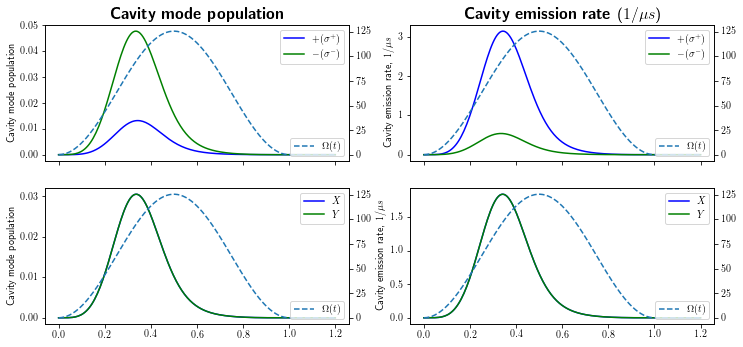

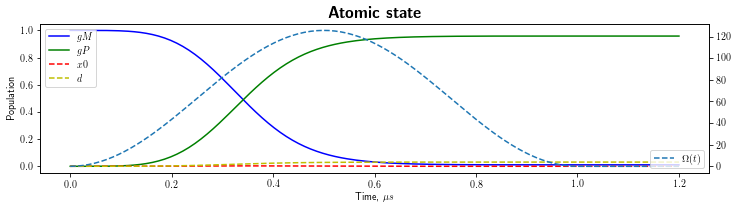

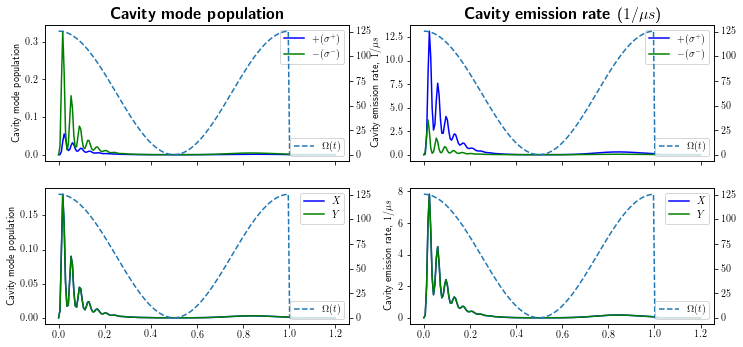

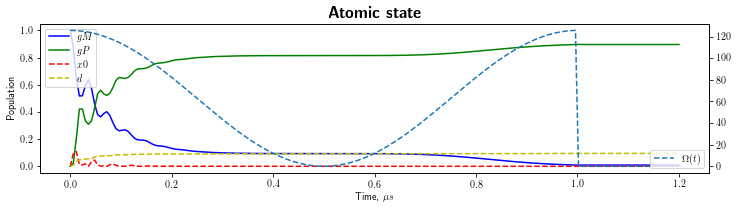

In [6]:
plot_results(results)
plot_results(results2)

###Define functions a 'fourier_pulse'

To have an arbitrary driving pulse we use a fourier series.

In [12]:
def fourier_series(a0=0,ans=[],bns=[]):
    return lambda x: a0 + sum([an * np.cos(n*x) + bn * np.sin(n*x) for an, bn, n in zip(ans,bns,np.arange(1,len(ans)+1))])

def fourier_pulse(a0=0,ans=[],bns=[]):
    return lambda t, a0=a0, ans=ans, bns=bns: np.piecewise(t,
                                  [t<length_pulse],
                                  [a0 + np.sum([an * np.cos(n*(np.pi/length_pulse)*t) + 
                                                bn * np.sin(n*(np.pi/length_pulse)*t)
                                                for an, bn, n in zip(ans,bns,np.arange(1,len(ans)+1))]),
                                  0])

def fourier_pulse_verbose(a0=0,ans=[],bns=[]):
    a1, a2, a3 = ans
    b1, b2, b3 = bns
    return lambda t, a0=a0, a1=a1, a2=a2, a3=a3, b1=b1, b2=b2, b3=b3:\
        np.piecewise(t,
                    [t<length_pulse],
                      [a0 + 
                      a1 * np.cos((np.pi/length_pulse)*t) + 
                      a2 * np.cos(2*(np.pi/length_pulse)*t) +
                      a3 * np.cos(3*(np.pi/length_pulse)*t) +
                      b1 * np.sin((np.pi/length_pulse)*t) + 
                      b2 * np.sin(2*(np.pi/length_pulse)*t) + 
                      b3 * np.sin(3*(np.pi/length_pulse)*t),
                      0])

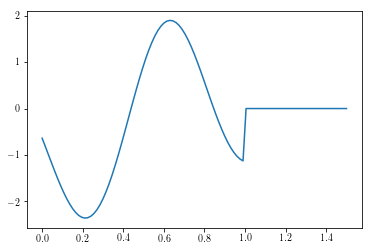

In [8]:
length_pulse=1.0

n_coeffs = 3
# f=fourier_pulse(0,np.random.uniform(-1,1,n_coeffs),np.random.uniform(-1,1,n_coeffs))
f=fourier_pulse_verbose(0,np.random.uniform(-1,1,n_coeffs),np.random.uniform(-1,1,n_coeffs))

t=np.linspace(0,length_pulse*1.5,101)
plt.plot(t,[f(x) for x in t])

In [8]:
ans=np.zeros(10).astype(np.int64)
ans[0]=1
bns=np.zeros(10).astype(np.int64)

laser_coupling = LaserCoupling(omega0=omega0,
                               g="gM",
                               x="x0",
                               deltaL=0,
                               args_ham={"length_pulse":1,
                                         "a0":0,
                                         "ans":ans,
                                         "bns":bns},
                               pulse_shape=("np.piecewise(t,"
                                            "[t<length_pulse],"
                                            "[a0 +" 
                                            "np.abs(np.sum([an * np.sin(n*(np.pi/length_pulse)*t) +" 
                                                    "bn * np.cos(n*(np.pi/length_pulse)*t)"
                                                    "for an, bn, n in zip(ans,bns,np.arange(1,len(ans)+1))]))" 
                                            ","
                                            "0])")
                               )

runner = ExperimentalRunner(atom=atom,
                            cavity=cavity,
                            laser_couplings=[laser_coupling],
                            cavity_couplings=cavity_couplings,
                            verbose=True)
    
    # results = runner.run(psi0=psi0, n_steps=n_steps, t_length=t_length)
# results = runner.run(psi0=psi0)


Pre-compiled Hamiltonian, ExperimentalRunner_Hamiltonian_0.pyx, is suitable to run this experiment.


Running simulation with 201 timesteps...

finished in 1.931 seconds
	Found suitable _EmissionOperators obj for setup.
	Found suitable _NumberOperators obj for setup.
	Found suitable _AtomicOperators obj for setup.
	Found suitable pre-computed number operator series.
	Found suitable pre-computed emission operator series.
	Found suitable pre-computed number operator series.
	Found suitable pre-computed emission operator series.
Photon emission: 0.966
Photon emission in |X>, |Y>: 0.483 0.483
Spontaneous emission: 0.031


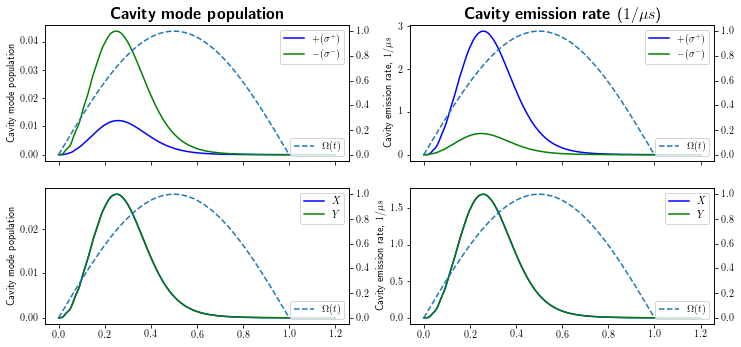

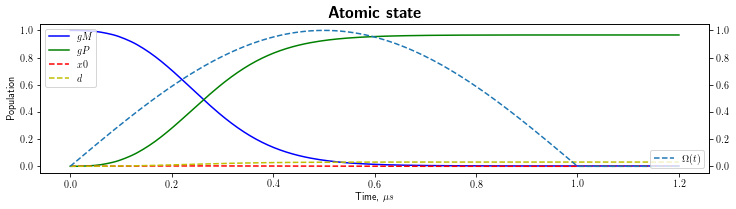

In [7]:
t_length=1.2
n_steps=201
psi0=['gM',0,0]

results = runner.run(psi0=psi0)

plot_results(results)

### Get learning

Ok, getting serious lets consider optimising the driving pulses, initially restricting them to be only sin pulses.

In [4]:
from scipy.optimize import fmin_cg, differential_evolution
import time

In [5]:
'''
Set up system
'''
gamma=3 * 2. * np.pi
branching_ratios = [0,0,1]

atom=Atom(gamma=gamma, branching_ratios=branching_ratios)

g0=24 * (2*np.pi)
kappa1,kappa2 = 19 * 2.*np.pi, 0.9 * 2.*np.pi
deltaP = 20 * 2.*np.pi

cavity=Cavity(g=g0, kappa1=kappa1, kappa2=kappa2, deltaP=deltaP)

deltaL=0
length_pulse = 1
omega0=20 * 2 * np.pi

laser_coupling = LaserCoupling(omega0=omega0,
                               g='gM',
                               x='x0',
                               deltaL=0,
                               args_ham={"length_pulse":length_pulse,"p_pulse":2},
                               pulse_shape='np.piecewise(t, [t<length_pulse], [np.sin((np.pi/length_pulse)*t)**p_pulse,0])'
                               )

deltaC=0
cavity_couplings = []

for g_state, x_state, delta, deltaM in Atom.get_couplings_sigma_minus(deltaC):
    cavity_couplings.append(CavityCoupling(g0=cavity.g,
                                           g=g_state,
                                           x=x_state,
                                           deltaC=delta,
                                           deltaM=deltaM))

In [37]:
t_length=1.2
n_steps=201
psi0=['gM',0,0]

def run_exp(args):
    omega, length_pulse, p_pulse =args
    
    laser_coupling.omega0 = omega
    laser_coupling.args_ham['length_pulse'] = length_pulse
    laser_coupling.args_ham['p_pulse'] = p_pulse
        
    runner = ExperimentalRunner(atom=atom,
                            cavity=cavity,
                            laser_couplings=[laser_coupling],
                            cavity_couplings=cavity_couplings,
                            verbose=False)
    
    # results = runner.run(psi0=psi0, n_steps=n_steps, t_length=t_length)
    results = runner.run(psi0=psi0)

    return 1-results.get_atomic_population(['gP'])[0][-1]

In [38]:
i=0
def c_back(x, convergence):
    global i
    i+=1
    print('\tFinished epoch: ', i)

t_start = time.time()
np.seterr(divide='ignore', invalid='ignore')
output_de = differential_evolution(run_exp,
                                   [[0.05,50*2*np.pi],[0.05,1],[0,5]],
                                   maxiter=1,
                                   callback=c_back)
print('finished in {0}s'.format(time.time() - t_start))
print('''Differential evolution output:
      Atomic transfer: {0}
      (omega0, pulse_length, p_pulse): {1}MHz, {2}us, {3}'''.format(
          1-output_de.fun,
          * output_de.x * [1/(2*np.pi), 1,1])
    )

	Finished epoch:  1


	Finished epoch:  2


	Finished epoch:  3


	Finished epoch:  4


	Finished epoch:  5


	Finished epoch:  6


	Finished epoch:  7


finished in 193.51377892494202s
Differential evolution output:
      Atomic transfer: 0.9685064116587886
      (omega0, pulse_length, p_pulse): 30.78133900474368MHz, 0.9972261867177229us, 1.7946063728461659


Ok, so let's do this with a fourier series...

In [15]:
n_coeffs = 3

ans=np.zeros(n_coeffs).astype(float)
ans[0]=1
bns=np.zeros(n_coeffs).astype(float)

laser_coupling = LaserCoupling(omega0=omega0,
                               g="gM",
                               x="x0",
                               deltaL=0,
                               args_ham={"length_pulse":1,
                                         "a0":0,
                                         "ans":ans,
                                         "bns":bns},
                               pulse_shape=("np.piecewise(t,"
                                            "[t<length_pulse],"
                                            "[a0 +" 
                                            "np.abs(np.sum([an * np.sin(n*(np.pi/length_pulse)*t) +" 
                                                    "bn * np.cos(n*(np.pi/length_pulse)*t)"
                                                    "for an, bn, n in zip(ans,bns,np.arange(1,len(ans)+1))]))" 
                                            ","
                                            "0])")
                               )

In [16]:
t_length=1.2
n_steps=201
psi0=['gM',0,0]

def run_exp(args):
    omega, a0 = args[:2]
    coeffs = args[2:]
        
    len_coeffs = int(len(coeffs)/2)
    
    ans, bns = coeffs[:len_coeffs], coeffs[len_coeffs:]
    # print(ans)
    # print(bns)
    
    laser_coupling.omega0 = omega
    laser_coupling.args_ham['a0'] = a0
    laser_coupling.args_ham['ans'] = np.array(ans).astype(float)
    laser_coupling.args_ham['bns'] = np.array(bns).astype(float)   
    
    runner = ExperimentalRunner(atom=atom,
                            cavity=cavity,
                            laser_couplings=[laser_coupling],
                            cavity_couplings=cavity_couplings,
                            verbose=False)
    
    # results = runner.run(psi0=psi0, n_steps=n_steps, t_length=t_length)
    results = runner.run(psi0=psi0)

    # print(1-results.get_atomic_population(['gP'])[0][-1])
    return 1-results.get_atomic_population(['gP'])[0][-1]

In [17]:
i=0
def c_back(x, convergence):
    global i
    i+=1
    print('\tFinished epoch: ', i)

omega_range = [0.0,50.0*2*np.pi]
coeff_range = [0.0,1.0]

t_start = time.time()
np.seterr(divide='ignore', invalid='ignore')
output_de = differential_evolution(run_exp,
                                   [omega_range] + [coeff_range]*(2*n_coeffs+1),
                                   maxiter=1,
                                   callback= c_back)
print('finished in {0}s'.format(time.time() - t_start))
print('''Differential evolution output:
      Atomic transfer: {0}
      '''.format(
          1-output_de.fun
    )
    )

	Finished epoch:  1


finished in 363.1182141304016s
Differential evolution output:
      Atomic transfer: 0.944468145037818
      


Pre-compiled Hamiltonian, ExperimentalRunner_Hamiltonian_0.pyx, is suitable to run this experiment.
Running simulation with 201 timesteps...

finished in 0.726 seconds
	Found suitable _EmissionOperators obj for setup.
	Found suitable _NumberOperators obj for setup.
	Found suitable _AtomicOperators obj for setup.
Photon emission: 0.944
Photon emission in |X>, |Y>: 0.472 0.472
Spontaneous emission: 0.052


lambda t_list: [np.piecewise(t,[t<1],[0.733284577968 +np.abs(np.sum([an * np.sin(n*(np.pi/1)*t) +bn * np.cos(n*(np.pi/1)*t)for an, bn, n in zip([0.512311421929775, 0.7145348817090353, 0.17102129930082682],[0.5853773935645455, 0.008712730238762102, 0.03813926015648044],np.arange(1,len([0.512311421929775, 0.7145348817090353, 0.17102129930082682])+1))])),0]) for t in t_list]
<function <lambda> at 0x11cbe47b8>


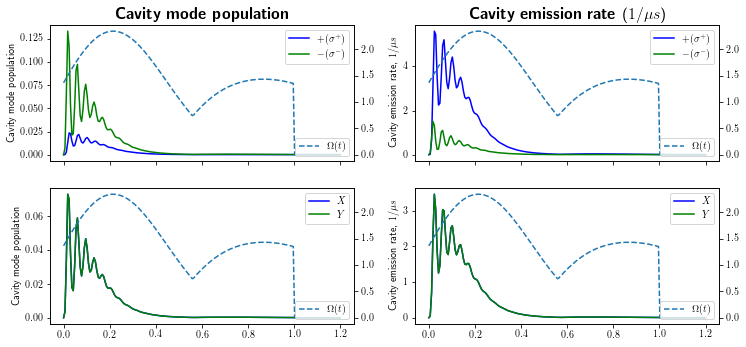

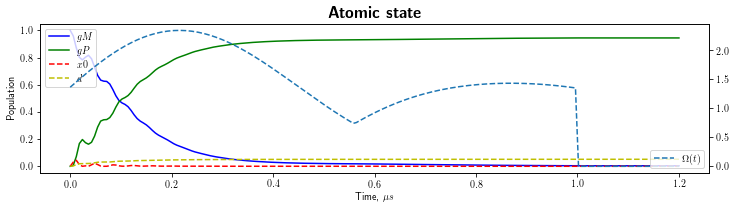

In [18]:
args = output_de.x

omega, a0 = args[:2]
coeffs = args[2:]
len_coeffs = int(len(coeffs)/2)
ans, bns = coeffs[:len_coeffs], coeffs[len_coeffs:]

laser_coupling.omega0 = omega
laser_coupling.args_ham['a0'] = a0
laser_coupling.args_ham['ans'] = np.array(ans).astype(float)
laser_coupling.args_ham['bns'] = np.array(bns).astype(float)
    
runner = ExperimentalRunner(atom=atom,
                        cavity=cavity,
                        laser_couplings=[laser_coupling],
                        cavity_couplings=cavity_couplings,
                        verbose=True)

# results = runner.run(psi0=psi0, n_steps=n_steps, t_length=t_length)
results = runner.run(psi0=psi0)

plot_results(results)

Now lets try it with an interpolation series...

In [4]:
from Cython.Compiler import Options as cyOptions
from scipy.interpolate import UnivariateSpline

In [5]:
n_points = 11

length_pulse=1
x_list=np.array(np.linspace(0,length_pulse,n_points)).astype(float)
y_list=np.sin((np.pi/length_pulse) * x_list).astype(float)

laser_coupling = LaserCoupling(omega0=omega0,
                               g="gM",
                               x="x0",
                               deltaL=0,
                               args_ham={"length_pulse":float(length_pulse),
                                         "x_list":x_list,
                                         "y_list":y_list},
                               pulse_shape=("np.piecewise(t,"
                                            "[t<=length_pulse],"
                                            "[UnivariateSpline(x_list,y_list,s=0.1,k=3)" 
                                            ","
                                            "0])"),
                               # setup_ham=["from scipy.interpolate import UnivariateSpline"]
                                setup_pyx=["from scipy.interpolate import UnivariateSpline"]

                               )
cyOptions.error_on_unknown_names = True
runner = ExperimentalRunner(atom=atom,
                            cavity=cavity,
                            laser_couplings=[laser_coupling],
                            cavity_couplings=cavity_couplings,
                            verbose=True)

No suitable pre-compiled Hamiltonian found.  Generating Cython file...

Exception in rhs comp...adding additional setups
...and trying rhs generate again


done.
	New file is ExperimentalRunner_Hamiltonian_0.pyx.  Generated in 5.264 seconds.


In [9]:
t_length=1.2
n_steps=201
psi0=['gM',0,0]

def run_exp(args):
    length_pulse, omega = args[:2]
    x_list=np.array(np.linspace(0,length_pulse,n_points)).astype(float)
    y_list = args[2:]
    
    laser_coupling.omega0 = omega
    laser_coupling.args_ham['length_pulse'] = length_pulse
    laser_coupling.args_ham['x_list'] = x_list
    laser_coupling.args_ham['y_list'] = y_list 
    
    runner = ExperimentalRunner(atom=atom,
                            cavity=cavity,
                            laser_couplings=[laser_coupling],
                            cavity_couplings=cavity_couplings,
                            verbose=False)
    
    # results = runner.run(psi0=psi0, n_steps=n_steps, t_length=t_length)
    results = runner.run(psi0=psi0)

    return 1-results.get_atomic_population(['gP'])[0][-1]

In [9]:
i=0
def c_back(x, convergence):
    global i
    i+=1
    print('\tFinished epoch: ', i)

length_range = [0.1,1.0]
omega_range = [0.0,50.0*2*np.pi]
coeff_range = [0,1]

t_start = time.time()
np.seterr(divide='ignore', invalid='ignore')
output_de = differential_evolution(run_exp,
                                   [length_range] + [omega_range] + [coeff_range]*n_points,
                                   maxiter=1,
                                   callback= c_back)
print('finished in {0}s'.format(time.time() - t_start))
print('''Differential evolution output:
      Atomic transfer: {0}
      '''.format(
          1-output_de.fun
    )
    )

	Finished epoch:  1


finished in 918.6284079551697s
Differential evolution output:
      Atomic transfer: 0.9680534983441339
      


Pre-compiled Hamiltonian, ExperimentalRunner_Hamiltonian_0.pyx, is suitable to run this experiment.
Running simulation with 201 timesteps...

finished in 0.563 seconds
	Found suitable _EmissionOperators obj for setup.
	Found suitable _NumberOperators obj for setup.
	Found suitable _AtomicOperators obj for setup.


Photon emission: 0.968
Photon emission in |X>, |Y>: 0.484 0.484
Spontaneous emission: 0.032


lambda t_list: [np.piecewise(t,[t<=0.884363047443],[UnivariateSpline([0.0, 0.0884363047443371, 0.1768726094886742, 0.2653089142330113, 0.3537452189773484, 0.4421815237216855, 0.5306178284660226, 0.6190541332103597, 0.7074904379546968, 0.7959267426990339, 0.884363047443371],[1.2816354026309432e-05, 0.1353849421205882, 0.293456099804969, 0.951373217974136, 0.5299172808245565, 0.2051802224849471, 0.9740174371218459, 0.994614004160249, 0.5090592356868591, 0.023599850291914165, 0.8266408990081026],s=0.1,k=3),0]) for t in t_list]
<function <lambda> at 0x111351c80>


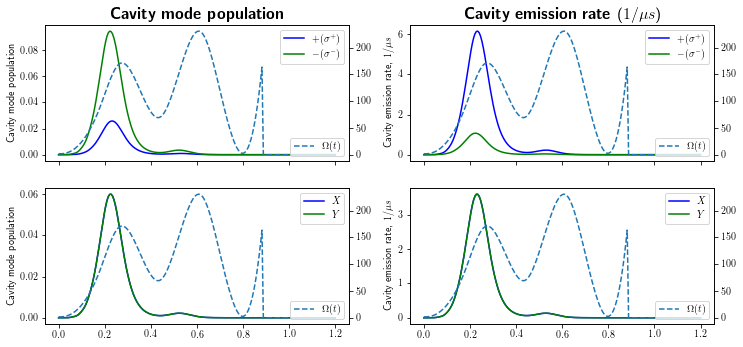

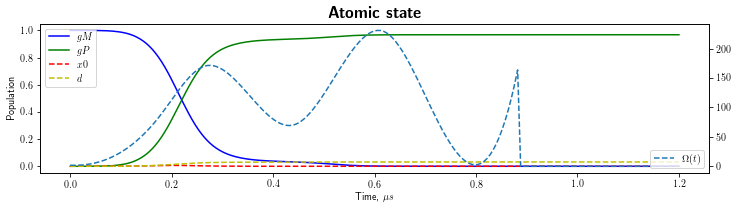

In [10]:
args = output_de.x

length_pulse, omega = args[:2]
x_list=np.array(np.linspace(0,length_pulse,n_points)).astype(float)
y_list = args[2:]
    
laser_coupling.omega0 = omega
laser_coupling.args_ham['length_pulse'] = length_pulse
laser_coupling.args_ham['x_list'] = x_list
laser_coupling.args_ham['y_list'] = y_list 

runner = ExperimentalRunner(atom=atom,
                        cavity=cavity,
                        laser_couplings=[laser_coupling],
                        cavity_couplings=cavity_couplings,
                        verbose=True)

# results = runner.run(psi0=psi0, n_steps=n_steps, t_length=t_length)
results = runner.run(psi0=psi0)

plot_results(results)

###Cython testing

In [4]:
import Cython
from Cython.Compiler import Options as cyOptions
from scipy.interpolate import UnivariateSpline

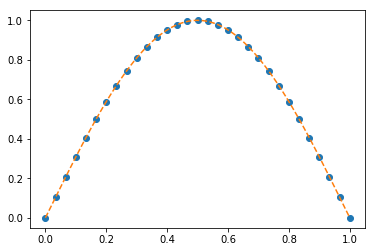

In [5]:
pulse_len = 1
x_list = np.linspace(0,pulse_len,31)
y_list = [np.sin((np.pi/pulse_len) * x) for x in x_list]

inter_fun = UnivariateSpline(x_list,y_list,s=0.1,k=5)

x_fine = np.linspace(0,pulse_len,101)

plt.plot(x_list,y_list,'o',x_fine,inter_fun(x_fine),'--');

In [6]:
length_pulse=0.8
x_list=np.array(np.linspace(0,length_pulse,11)).astype(float)
y_list=np.sin((np.pi/length_pulse) * x_list)

laser_coupling = LaserCoupling(omega0=omega0,
                               g="gM",
                               x="x0",
                               deltaL=0,
                               args_ham={"length_pulse":length_pulse,
                                         "x_list":x_list,
                                         "y_list":y_list},
                               pulse_shape=("np.piecewise(t,"
                                            "[t<=length_pulse],"
                                            "[UnivariateSpline(x_list,y_list,s=0.1,k=3)" 
                                            ","
                                            "0])"),
                               setup_pyx=["from scipy.interpolate import UnivariateSpline"],
                               add_pyx=['']
                               )

Cython.Compiler.Options.error_on_unknown_names = True
runner = ExperimentalRunner(atom=atom,
                            cavity=cavity,
                            laser_couplings=[laser_coupling],
                            cavity_couplings=cavity_couplings,
                            verbose=True)

No suitable pre-compiled Hamiltonian found.  Generating Cython file...


	Exception in rhs comp...adding additional setups...and trying rhs generate again...

done.
	New file is ExperimentalRunner_Hamiltonian_0.pyx.  Generated in 5.641 seconds.


Running simulation with 201 timesteps...

finished in 0.418 seconds
	Creating new _EmissionOperators obj for setup.
	Creating new _NumberOperators obj for setup.
	Creating new _AtomicOperators obj for setup.
	Creating new number operator series.
	Creating new number operator series.


	Creating new number operator series.


	Creating new number operator series.


Photon emission: 0.961
Photon emission in |X>, |Y>: 0.48 0.48
Spontaneous emission: 0.031


lambda t_list: [np.piecewise(t,[t<=0.8],[UnivariateSpline([0.0, 0.08, 0.16, 0.24, 0.32, 0.4, 0.48, 0.56, 0.64, 0.72, 0.8],[0.0, 0.3090169943749474, 0.5877852522924731, 0.8090169943749473, 0.9510565162951535, 1.0, 0.9510565162951536, 0.8090169943749475, 0.5877852522924732, 0.3090169943749475, 1.2246467991473532e-16],s=0.1,k=3),0]) for t in t_list]
<function <lambda> at 0x11a416620>


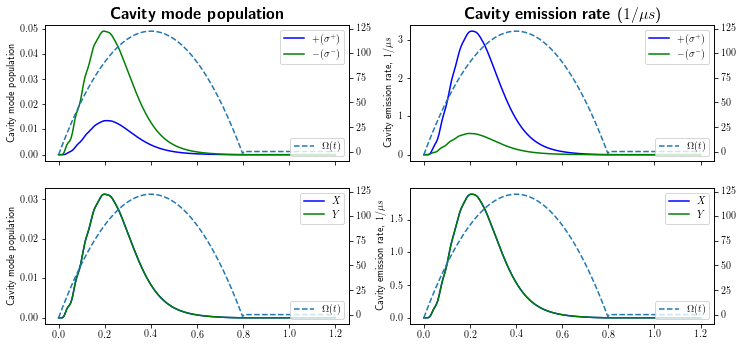

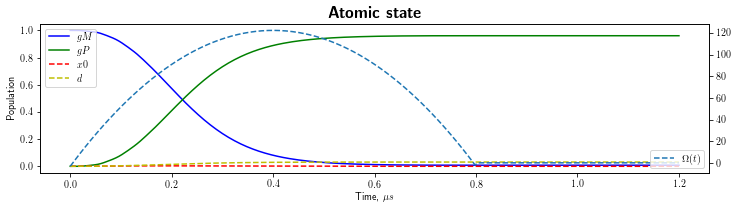

In [13]:
t_length=1.2
n_steps=201
psi0=['gM',0,0]

results = runner.run(psi0=psi0)

plot_results(results)

###Cython testing (with c interpolation)

So now we want to do the interpolation in c to speed these simulations up.  To do this I'm going to steal the interp function from qutip.cy.interpolate and steal the __init__ of the Qutip Cubic_Spline class to pre-calculate the coefficients.

We can't use the Cubic_Spline class Qutip provides for passing interpolated functions as time-dependent coefficients as these must be used as the sole time-dependent argument to a given part of the Hamiltonian.  However in our case the laser pulse is only one of the factors we use,

e.g.  This would work
	H = [H0, [H1, <Cubic_Spline obj>], [H2, 'sin(t)'], ...]

However we need this, which doesn't.
	H = [H0, [H1, 'sin(t)'*<Cubic_Spline obj>], ...]

In [10]:
import scipy.linalg as la

'''
This is code is taken from the Cubic_Spline.__init__(...) function.
'''
def get_spline_coeffs(a, b, y, alpha=0, beta=0):

    y = np.asarray(y)
    n = y.shape[0] - 1
    h = (b - a)/n

    coeff = np.zeros(n + 3, dtype=y.dtype)
    # Solutions to boundary coeffcients of spline
    coeff[1] = 1/6. * (y[0] - (alpha * h**2)/6) #C2 in paper
    coeff[n + 1] = 1/6. * (y[n] - (beta * h**2)/6) #cn+2 in paper

    # Compressed tridiagonal matrix 
    ab = np.ones((3, n - 1), dtype=float)
    ab[0,0] = 0 # Because top row is upper diag with one less elem
    ab[1, :] = 4
    ab[-1,-1] = 0 # Because bottom row is lower diag with one less elem
    
    B = y[1:-1].copy() #grabs elements y[1] - > y[n-2] for reduced array
    B[0] -= coeff[1]
    B[-1] -=  coeff[n + 1]

    coeff[2:-2] = la.solve_banded((1, 1), ab, B, overwrite_ab=True, 
                    overwrite_b=True, check_finite=False)

    coeff[0] = alpha * h**2/6. + 2 * coeff[1] - coeff[2]
    coeff[-1] = beta * h**2/6. + 2 * coeff[-2] - coeff[-3]
    
    return coeff

In [11]:
length_pulse=0.8
x_list=np.array(np.linspace(0,length_pulse,11)).astype(float)
y_list=np.sin((np.pi/length_pulse) * x_list)

coeffs = get_spline_coeffs(x_list[0],x_list[-1],y_list)

pulse_c_str = \
'''
@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double complex pulse_c(float t, float t_start, float t_end, double[::1] coeffs):
    if t<t_end: return interp(t, t_start, t_end, coeffs)
    else: return 0
'''

laser_coupling = LaserCoupling(omega0=omega0,
                               g="gM",
                               x="x0",
                               deltaL=0,
                               args_ham={"n_points": len(x_list),
                                         "x_list": x_list,
                                         "y_list": y_list,
                                         "pulse_coeffs": coeffs},
                               pulse_shape=("pulse_c(t, x_list[0], x_list[n_points-1], pulse_coeffs)"),
                               setup_pyx=['  '],
                               add_pyx=[pulse_c_str]
                               )

Cython.Compiler.Options.error_on_unknown_names = True
runner = ExperimentalRunner(atom=atom,
                            cavity=cavity,
                            laser_couplings=[laser_coupling],
                            cavity_couplings=cavity_couplings,
                            verbose=True)

No suitable pre-compiled Hamiltonian found.  Generating Cython file...


	Exception in rhs comp...adding additional setups...and trying rhs generate again...

done.
	New file is ExperimentalRunner_Hamiltonian_1.pyx.  Generated in 5.754 seconds.


99.3 ms ± 7.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	Creating new number operator series.


	Creating new number operator series.
	Creating new number operator series.


	Creating new number operator series.
Photon emission: 

0.961
Photon emission in |X>, |Y>: 0.48 0.48
Spontaneous emission: 0.031


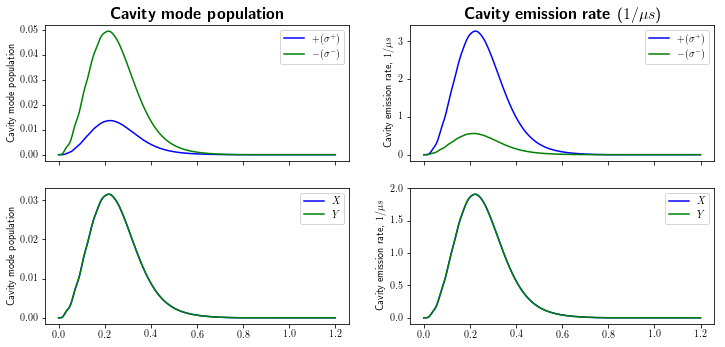

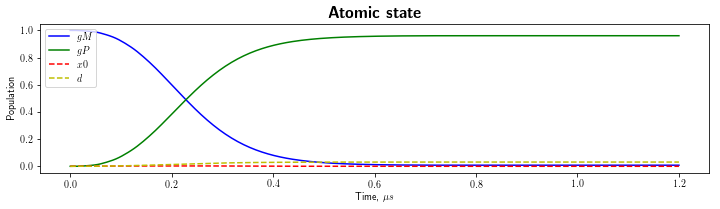

In [12]:
t_length=1.2
n_steps=201
psi0=['gM',0,0]

%timeit -n 10 results = runner.run(psi0=psi0)
results = runner.run(psi0=psi0)

plot_results(results, plot_pulse=False)

In [6]:
%timeit -n100 results.get_atomic_population(['gP'])[0][-1]
%timeit -n100 results.get_atomic_population(['gP'],-1)

1.48 ms ± 84.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.1 µs ± 1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
print(results.get_atomic_population(['gP'],-1)[-1])
print(results.get_atomic_population(['gP'])[0][-1])

0.958277304765
0.958277304765
